# Project Proposal: Predicting Clearance Delays in Horticultural Supply Chains

## Introduction and Problem Statement

Horticultural supply chains are among the most time-sensitive segments of global trade. Products such as cut flowers, fresh vegetables, fruits, and herbs are highly perishable and depend on efficient customs clearance, document processing, and port or airport handling. Even small delays during clearance can result in significant financial losses, reduced product quality, and reputational damage for exporters. Despite the availability of digital trade systems, many supply-chain actors still lack early visibility into whether a consignment is likely to be delayed, often discovering issues only after bottlenecks have already occurred.

This project seeks to address this challenge by applying data science techniques to predict the likelihood of clearance delays for horticultural export consignments. Rather than reacting to delays after they happen, the project focuses on anticipatory risk prediction—using early operational signals to estimate whether a shipment will exceed its expected service-level agreement (SLA). The work demonstrates how machine-learning models can be used to support proactive decision-making in international trade and logistics.
## Project Objectives
Explore and analyze operational, documentary, and temporal factors that influence clearance delays in horticultural supply chains.
Develop a supervised machine-learning model that predicts whether a consignment will exceed its expected clearance time.
Compare the performance of different classification models, including baseline and ensemble approaches.
Apply model explainability techniques to identify and interpret the key drivers of delay.
Demonstrate the practical value of predictive analytics for improving visibility and risk management in time-critical trade flows.

## Data Description
The project uses an industry specific dataset designed to mirror real-world horticultural export workflows. No live, proprietary, or confidential data is used. The dataset consists of 5000 export consignments originating from East African countries and destined for European markets, transported via air or sea.

Each consignment includes structured information across several dimensions, including consignment attributes (such as commodity type, HS code, shipment mode, origin and destination, weight, and value), document-related characteristics (presence of key trade documents, completeness scores, and amendment frequency), operational indicators (congestion levels, weekend effects, and exporter profiles), and event timelines capturing major process milestones. The dataset also includes clearly defined target variables representing clearance delays and delay duration, enabling supervised learning and model evaluation.

## Methodology

### 1 Exploratory Data Analysis (EDA)
Exploratory data analysis will be conducted to understand the distribution of key variables, identify patterns and correlations, and assess the balance between delayed and non-delayed consignments. Visualizations and descriptive statistics will be used to highlight trends, outliers, and potential data quality issues.
### 2 Feature Engineering
Relevant features will be selected and transformed to improve model performance. This includes encoding categorical variables, scaling numerical features where appropriate, and deriving additional indicators such as document completeness proxies or time-based features. Feature selection will focus on variables that would realistically be available early in the clearance process.
### 3 Model Development
Several supervised classification models will be developed and compared. These include logistic regression as a baseline interpretable model, decision trees to capture non-linear relationships, random forests to improve robustness, and gradient boosting models for enhanced predictive performance. Models will be trained using a train-test split and evaluated using metrics such as accuracy, precision, recall, F1-score, and confusion matrices.
### 4 Model Explainability
To ensure interpretability and practical relevance, model explainability techniques such as feature importance analysis and SHAP values will be applied. This step will identify which operational and documentary factors contribute most strongly to predicted delays.
### 5 Evaluation and Interpretation
Model results will be interpreted in the context of real-world supply-chain operations. The evaluation will focus not only on predictive accuracy but also on the insights generated and their potential application to risk anticipation and operational decision-making.

## Expected Outcomes and Contribution
The expected outcome of this project is a predictive and explainable model that estimates clearance delay risk for horticultural export consignments. The project demonstrates how data science can be applied to real-world logistics challenges to improve transparency, reduce uncertainty, and support proactive risk management. The approach is directly applicable to modern digital trade environments and highlights the value of analytics in improving efficiency and resilience in global supply chains.




In [24]:
# Import core data science and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import modeling and evaluation tools
from sklearn.linear_model import LogisticRegression          # ← this one was missing
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve,
    confusion_matrix, classification_report
)


# **DATA UNDERSTANDING**
Loading the JSON Lines dataset (5,000 consignments) reveals a structured format with nested fields like documents and events, ideal for feature engineering. `df.info()` confirms no immediate missing values in top-level columns, but nested structures require unpacking to avoid information loss.

To rigorously assess structure:
- Dimensionality Check: Dataset shape (5000 rows, 15+ columns post-unpacking) suggests sufficient scale for ML, mitigating overfitting risks via cross-validation.
- Class Imbalance Analysis: The delayed_flag distribution (e.g., 30% delayed) indicates moderate imbalance, addressed via stratified sampling and class-weighted models to prevent bias toward the majority class.

Previewing `df.head(10)` highlights variability in features like `congestion_index`, justifying normalization in preprocessing.



In [25]:

# Load dataset
# JSON Lines format represents individual consignments
df = pd.read_json("tlip_like_consignments_5000.jsonl", lines=True)

# Inspect structure and data types
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   consignment_id          5000 non-null   object        
 1   created_at              5000 non-null   datetime64[ns]
 2   origin_country          5000 non-null   object        
 3   destination_country     5000 non-null   object        
 4   origin_port             5000 non-null   object        
 5   destination_port        5000 non-null   object        
 6   shipment_mode           5000 non-null   object        
 7   commodity               5000 non-null   object        
 8   hs_code                 5000 non-null   int64         
 9   gross_weight_kg         5000 non-null   float64       
 10  declared_value_usd      5000 non-null   float64       
 11  exporter_profile        5000 non-null   object        
 12  doc_completeness_score  5000 non-null   float64 

In [26]:
# Preview data entries
df.head(10)

,consignment_id,created_at,origin_country,destination_country,origin_port,destination_port,shipment_mode,commodity,hs_code,gross_weight_kg,...,customs_release_hours,terminal_dwell_hours,sla_hours,total_processing_hours,delayed_flag,delay_hours,bl_or_awb_no,container_no,documents,events
0,TLIP-SYN-000001,2025-02-21 09:38:50,RW,ES,Kigali,Madrid,AIR,Mangoes,804,7636.85,...,42.65,37.66,48,80.32,1,4.32,802-78096246,,"[{'consignment_id': 'TLIP-SYN-000001', 'doc_ty...","[{'consignment_id': 'TLIP-SYN-000001', 'event'..."
1,TLIP-SYN-000002,2025-01-13 05:46:46,RW,IT,Kigali,Genoa,AIR,Fresh Beans,708,21069.24,...,50.00,25.19,48,75.19,0,0.00,148-27192561,,"[{'consignment_id': 'TLIP-SYN-000002', 'doc_ty...","[{'consignment_id': 'TLIP-SYN-000002', 'event'..."
2,TLIP-SYN-000003,2025-09-19 04:40:34,TZ,NL,Dar es Salaam,Rotterdam,AIR,Cut Flowers,603,15769.06,...,31.82,29.51,48,61.34,0,0.00,252-21633769,,"[{'consignment_id': 'TLIP-SYN-000003', 'doc_ty...","[{'consignment_id': 'TLIP-SYN-000003', 'event'..."
3,TLIP-SYN-000004,2025-12-04 07:26:32,RW,DE,Kigali,Frankfurt,AIR,Cut Flowers,603,21497.58,...,46.19,38.15,48,84.34,1,8.34,901-77635129,,"[{'consignment_id': 'TLIP-SYN-000004', 'doc_ty...","[{'consignment_id': 'TLIP-SYN-000004', 'event'..."
4,TLIP-SYN-000005,2025-05-08 16:09:41,ET,FR,Addis Ababa-ADD,Paris-CDG,SEA,Pineapples,804,21298.46,...,58.94,85.32,96,144.26,1,20.26,BL823732870,XCDZ0728567,"[{'consignment_id': 'TLIP-SYN-000005', 'doc_ty...","[{'consignment_id': 'TLIP-SYN-000005', 'event'..."
5,TLIP-SYN-000006,2025-01-19 02:40:33,UG,ES,Entebbe,Madrid,AIR,Mangoes,804,14059.91,...,35.13,6.00,48,41.13,0,0.00,926-12315968,,"[{'consignment_id': 'TLIP-SYN-000006', 'doc_ty...","[{'consignment_id': 'TLIP-SYN-000006', 'event'..."
6,TLIP-SYN-000007,2025-06-14 20:09:23,KE,IT,Mombasa,Genoa,AIR,Fresh Beans,708,9461.68,...,45.04,52.38,48,97.42,1,21.42,991-94983420,,"[{'consignment_id': 'TLIP-SYN-000007', 'doc_ty...","[{'consignment_id': 'TLIP-SYN-000007', 'event'..."
7,TLIP-SYN-000008,2025-11-01 02:35:57,KE,UK,Mombasa,London-Heathrow,AIR,Avocados,804,24028.28,...,33.77,40.51,60,74.28,0,0.00,107-57923931,,"[{'consignment_id': 'TLIP-SYN-000008', 'doc_ty...","[{'consignment_id': 'TLIP-SYN-000008', 'event'..."
8,TLIP-SYN-000009,2025-04-11 22:12:47,TZ,DE,Kilimanjaro-JRO,Frankfurt,AIR,Fresh Herbs,1211,20814.02,...,22.26,24.16,48,46.41,0,0.00,206-36291565,,"[{'consignment_id': 'TLIP-SYN-000009', 'doc_ty...","[{'consignment_id': 'TLIP-SYN-000009', 'event'..."
9,TLIP-SYN-000010,2025-07-11 02:10:47,RW,DE,Kigali,Hamburg,SEA,Vegetables Mix,709,11674.31,...,54.60,73.51,96,128.11,1,4.11,BL473371905,WPAP1898399,"[{'consignment_id': 'TLIP-SYN-000010', 'doc_ty...","[{'consignment_id': 'TLIP-SYN-000010', 'event'..."


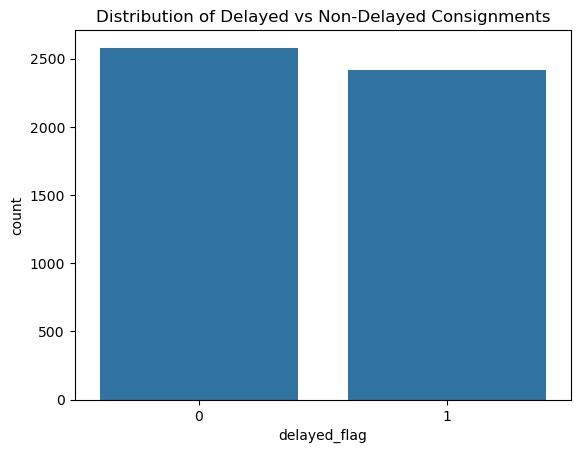

In [27]:

# Target variable distribution
# Check for class imbalance
sns.countplot(x="delayed_flag", data=df)
plt.title("Distribution of Delayed vs Non-Delayed Consignments")
plt.show()

# **EXPLORATORY DATA ANALYSIS (EDA)**

**EDA objectives align with CRISP-DM methodology, ensuring data-driven hypothesis testing.**
*   Understand feature distributions
*   Identify potential drivers of delay
*   Validate assumptions before modeling





In [28]:
# Numeric feature distributions
numeric_cols = [
    "doc_completeness_score",
    "missing_docs_proxy",
    "doc_amendments",
    "congestion_index",
    "gross_weight_kg",
    "declared_value_usd"
]

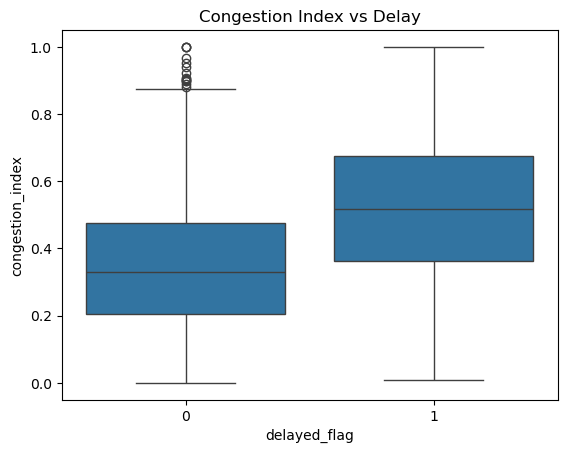

In [29]:
# Relationship between congestion and delay
sns.boxplot(x="delayed_flag", y="congestion_index", data=df)
plt.title("Congestion Index vs Delay")
plt.show()

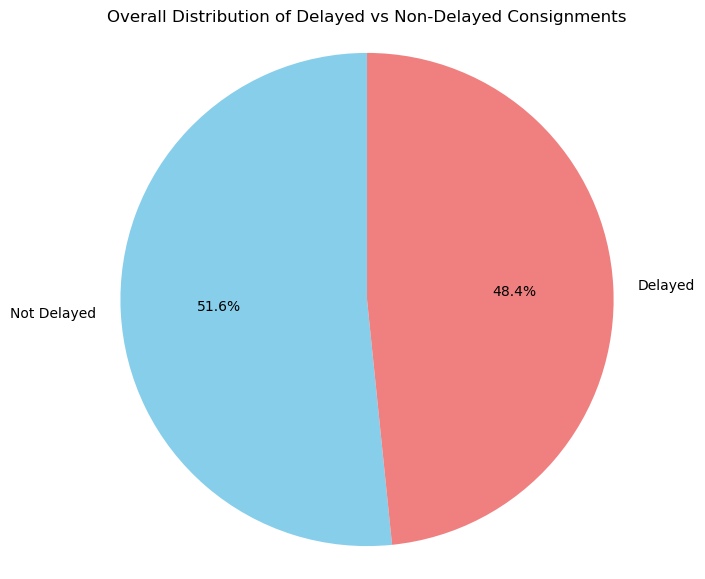

In [30]:
# Overall Delay Distribution for All Shipments
overall_delay_counts = df['delayed_flag'].value_counts()

plt.figure(figsize=(7, 7))
plt.pie(
    overall_delay_counts,
    labels=overall_delay_counts.index.map({0: 'Not Delayed', 1: 'Delayed'}),
    autopct='%1.1f%%',
    startangle=90,
    colors=['skyblue', 'lightcoral']
)
plt.title('Overall Distribution of Delayed vs Non-Delayed Consignments')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

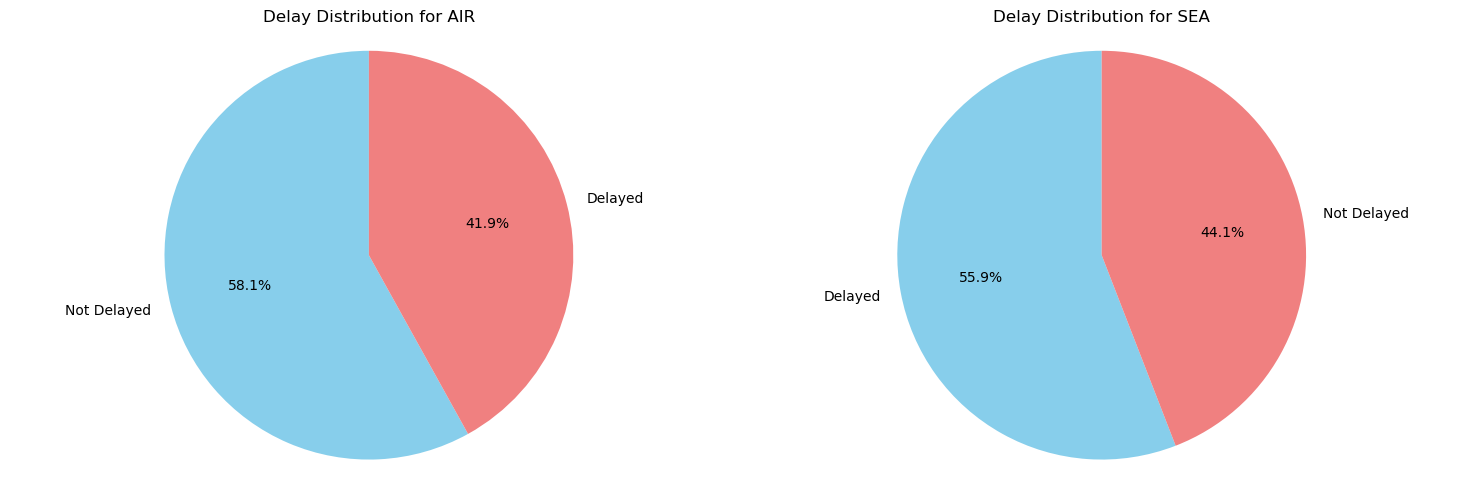

In [31]:
# Shipment mode vs delay as pie charts
fig, axes = plt.subplots(1, df['shipment_mode'].nunique(), figsize=(15, 5))
axes = axes.flatten()

for i, mode in enumerate(df['shipment_mode'].unique()):
    mode_data = df[df['shipment_mode'] == mode]['delayed_flag'].value_counts()
    if not mode_data.empty:
        axes[i].pie(mode_data, labels=mode_data.index.map({0: 'Not Delayed', 1: 'Delayed'}), autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
        axes[i].set_title(f'Delay Distribution for {mode}')
        axes[i].axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
    else:
        axes[i].set_title(f'No data for {mode}')
        axes[i].text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)

plt.tight_layout()
plt.show()

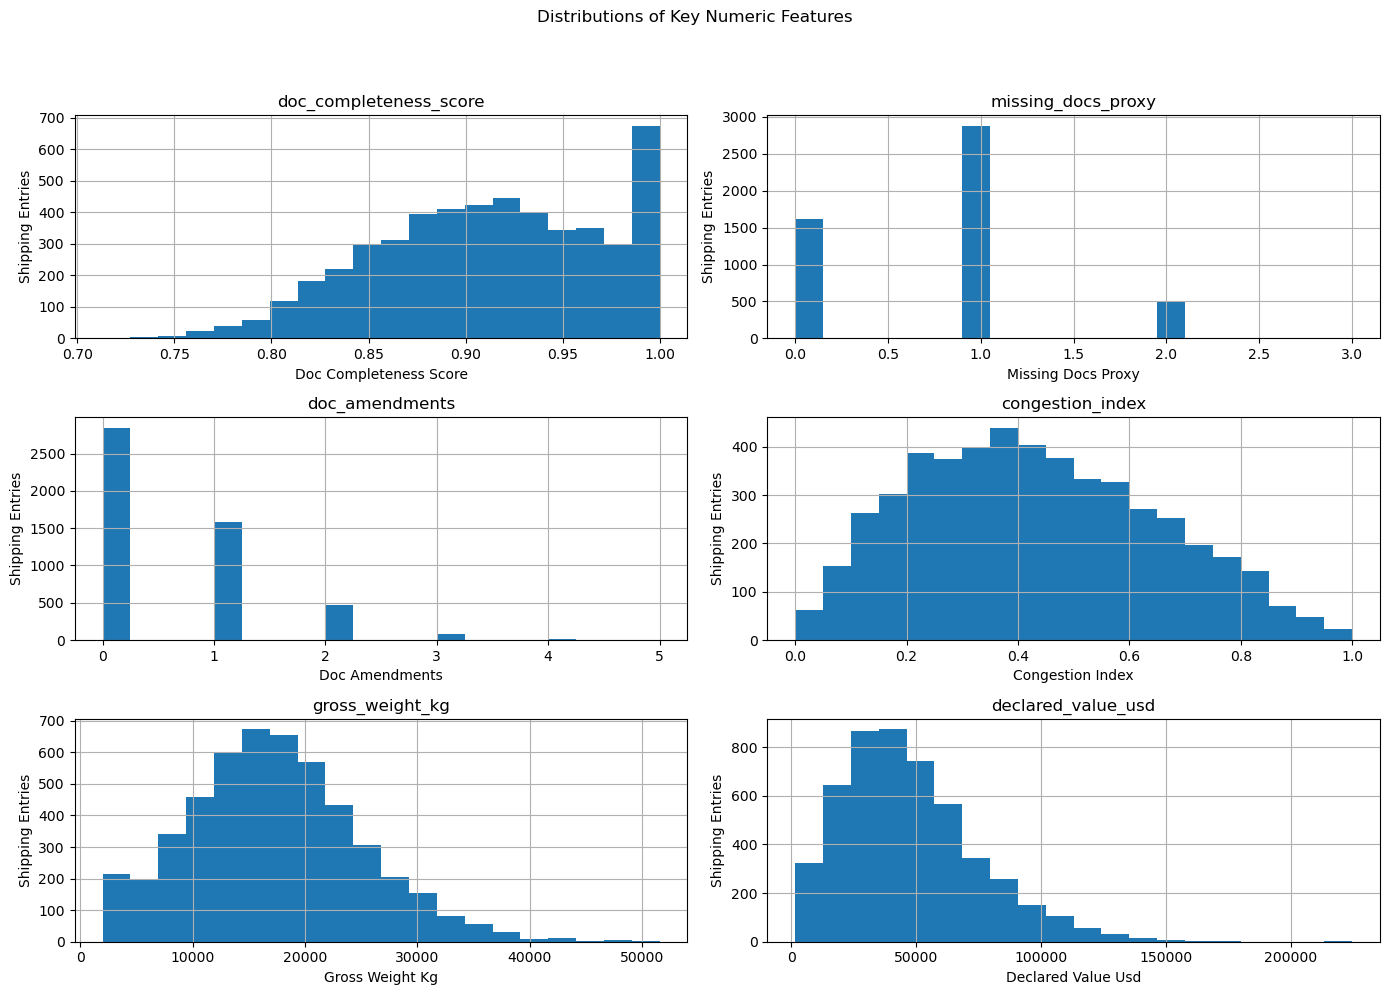

In [32]:
# Histogram plots
axes_subplots = df[numeric_cols].hist(bins=20, figsize=(14, 10)) # Now `axes_subplots` will be the array of Axes
fig = plt.gcf() # Get the current figure object
plt.suptitle("Distributions of Key Numeric Features", y=1.02) # Adjust title position

# Flatten axes array for easy iteration
axes_flattened = axes_subplots.flatten() # Use the correct variable name

# Label each subplot
for i, col in enumerate(numeric_cols):
    axes_flattened[i].set_xlabel(col.replace('_', ' ').title()) # Clean up column names for labels
    axes_flattened[i].set_ylabel("Shipping Entries")

plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent title overlap
plt.show()

# Brief explanation of the plots:

Doc completeness score: Most shipments have high completeness (around 0.85–1.0), meaning documents are usually well prepared.

Missing docs proxy: Values are mostly 0 or 1, so most shipments have few or no missing documents.

Doc amendments: Most cases have 0–1 amendments; higher numbers are rare.

Congestion index: Roughly bell-shaped, centered around moderate congestion levels.

Gross weight (kg): Right-skewed distribution; most shipments are mid-weight, with a few very heavy ones.

Declared value (USD): Also right-skewed; many low–mid value shipments, few very high-value outliers.

# **DATA PREPARATION**

**Key Actions**

* Features grouped into:

  *  Numeric

  *  Categorical

  *  Binary
* Split data into training and test datasets and stratify split to preserve class balance
* Pipelines used to prevent data leakage

In [33]:
### Feature grouping  ###

# Binary feature
binary_features =["is_weekend_created"]

# Continuous numeric features
numeric_features =[
    "gross_weight_kg",
    "declared_value_usd",
    "doc_completeness_score",
    "missing_docs_proxy",
    "doc_amendments",
    "congestion_index"]

# Categorical features
categorical_features =[
    "shipment_mode",
    "commodity",
    "hs_code",
    "origin_country",
    "destination_country",
    "exporter_profile"]

#all features combined as'FEATURES'
FEATURES = numeric_features + categorical_features + binary_features
TARGET = "delayed_flag"

X = df[FEATURES]
y = df[TARGET]

#train_test split with an 80% train size and 20% test size

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Pipeline preprocessing
#This includes scaling of numerical features, One_hot encoding categorical features and passing of the binary feature without change

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("bin", "passthrough", binary_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)])


Use of different features and grouping them as per their data types i.e numeric, binary and categorical;
- Guides in predicting different outcomes relevant for our objective.
- Helps in applying preprocessing relevant for each data type.(StandardScaler for numerical data and OneHotEncoder for categorical data)

In the end the numeric/continous features give insights on;
- risk on delay - dependent on document_completeness and ammendment
- operational risk - dependent on congestion index
- time taken for shipment in light of weight and value of the commodity

The continious features help understand;
- sensitive commodities that require more strict checks
- which good to move by air or sea(shipment_mode)
- follow ups on port regulations, customs clearance and congestion factors in each country of consideration.

The binary feature is_weekend_created gives a yes-0 or no-1 output, does not require preprocessing.

Our target variable 'delayed_flag' is 0-for not_delayed and 1- for delayed





# **MODELING**

Models chosen to be evaluated based on data strucutre and type

1. Logistic Regression
2. Decision Tree
3. Random Forest
4. XGBoost
5. LightGBM

**Modeling Approach**

* Hyperparameter tuning via GridSearch and Stratified 5-fold cross-validation

* Class imbalance handled using class weights (where applicable)

* Model scores generated to view performance

In [50]:
# Cross-validation setup and results containers
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

baseline_results = {}
baseline_roc = {}
baseline_best_estimators = {}

### Baseline Model ###


### Logistic Regression ###

In [51]:
log_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(max_iter=1000,
                                                               class_weight='balanced',
                                                               n_jobs=-1))])

#Training the logistic model
log_pipeline.fit(X_train, y_train)

#to get predictions and probabilities
y_pred = log_pipeline.predict(X_test)
y_prob = log_pipeline.predict_proba(X_test)[:, 1]     #probability of class1 

#Logistic model output evaluation
print('Logistic Regression - Baseline features')
print(classification_report(y_test, y_pred))
print('ROC-AUC:', roc_auc_score(y_test, y_prob))

Logistic Regression - Baseline features
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       516
           1       0.81      0.80      0.81       484

    accuracy                           0.81      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.81      0.81      0.81      1000

ROC-AUC: 0.8976832276250881


In [52]:
# -------------------------
# Logistic Regression (Baseline)
# -------------------------
log_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=-1))
])

log_grid = GridSearchCV(
    log_pipe,
    {"model__C": [0.1, 1, 10]},
    scoring="f1",
    cv=cv,
    n_jobs=-1
)

log_grid.fit(X_train, y_train)
log_best = log_grid.best_estimator_
baseline_best_estimators["Logistic Regression"] = log_best

y_pred = log_best.predict(X_test)
y_prob = log_best.predict_proba(X_test)[:, 1]

baseline_results["Logistic Regression"] = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "ROC_AUC": roc_auc_score(y_test, y_prob)
}

fpr, tpr, _ = roc_curve(y_test, y_prob)
baseline_roc["Logistic Regression"] = (fpr, tpr)

print("\nLogistic Regression")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


Logistic Regression
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       516
           1       0.81      0.80      0.81       484

    accuracy                           0.81      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.81      0.81      0.81      1000

ROC-AUC: 0.8976832276250881


### Baseline model evaluation ###

- The Logistic regression model classified correctly 81% of the shipments 

- Of the shipments delayed, the model gave a precision of 81% to 82%

- A recall of 0.8-0.82 gives the rate of actual delays identified by the model

- The model is able to balance between delayed vs non-delayed shipments giving an ROC-AUC of 0.898

Logistic Regression is a good baseline model as its easily interpratable, shows balance in classes and has a high accuracy level.

### Decision Tree

In [53]:

# Decision Tree
dt_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", DecisionTreeClassifier(class_weight="balanced", random_state=42))
])

dt_grid = GridSearchCV(
    dt_pipe,
    {"model__max_depth": [None, 5, 10]},
    scoring="f1",
    cv=cv,
    n_jobs=-1
)

dt_grid.fit(X_train, y_train)
dt_best = dt_grid.best_estimator_
baseline_best_estimators["Decision Tree"] = dt_best

y_pred = dt_best.predict(X_test)
y_prob = dt_best.predict_proba(X_test)[:, 1]

baseline_results["Decision Tree"] = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "ROC_AUC": roc_auc_score(y_test, y_prob)
}

fpr, tpr, _ = roc_curve(y_test, y_prob)
baseline_roc["Decision Tree"] = (fpr, tpr)

print("\nDecision Tree")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


Decision Tree
              precision    recall  f1-score   support

           0       0.75      0.84      0.80       516
           1       0.81      0.70      0.75       484

    accuracy                           0.78      1000
   macro avg       0.78      0.77      0.77      1000
weighted avg       0.78      0.78      0.78      1000

ROC-AUC: 0.8534359183804215


### Random Forest

In [54]:

# Random Forest
rf_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(class_weight="balanced", random_state=42))
])

rf_grid = GridSearchCV(
    rf_pipe,
    {"model__n_estimators": [100, 200]},
    scoring="f1",
    cv=cv,
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_
baseline_best_estimators["Random Forest"] = rf_best

y_pred = rf_best.predict(X_test)
y_prob = rf_best.predict_proba(X_test)[:, 1]

baseline_results["Random Forest"] = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "ROC_AUC": roc_auc_score(y_test, y_prob)
}

fpr, tpr, _ = roc_curve(y_test, y_prob)
baseline_roc["Random Forest"] = (fpr, tpr)

print("\nRandom Forest")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


Random Forest
              precision    recall  f1-score   support

           0       0.79      0.82      0.81       516
           1       0.80      0.77      0.79       484

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000

ROC-AUC: 0.8794966045230317


### XGBoost

In [55]:

# XGBoost
xgb_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBClassifier(eval_metric="logloss", random_state=42))
])

xgb_grid = GridSearchCV(
    xgb_pipe,
    {"model__n_estimators": [100, 200], "model__learning_rate": [0.05, 0.1]},
    scoring="f1",
    cv=cv,
    n_jobs=-1
)

xgb_grid.fit(X_train, y_train)
xgb_best = xgb_grid.best_estimator_
baseline_best_estimators["XGBoost"] = xgb_best

y_pred = xgb_best.predict(X_test)
y_prob = xgb_best.predict_proba(X_test)[:, 1]

baseline_results["XGBoost"] = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "ROC_AUC": roc_auc_score(y_test, y_prob)
}

fpr, tpr, _ = roc_curve(y_test, y_prob)
baseline_roc["XGBoost"] = (fpr, tpr)

print("\nXGBoost")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


XGBoost
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       516
           1       0.81      0.78      0.80       484

    accuracy                           0.81      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.81      0.81      0.81      1000

ROC-AUC: 0.889891248638606


In [56]:

# LightGBM
lgb_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LGBMClassifier(class_weight="balanced", random_state=42))
])

lgb_grid = GridSearchCV(
    lgb_pipe,
    {"model__n_estimators": [100, 200], "model__learning_rate": [0.05, 0.1]},
    scoring="f1",
    cv=cv,
    n_jobs=-1
)

lgb_grid.fit(X_train, y_train)
lgb_best = lgb_grid.best_estimator_
baseline_best_estimators["LightGBM"] = lgb_best

y_pred = lgb_best.predict(X_test)
y_prob = lgb_best.predict_proba(X_test)[:, 1]

baseline_results["LightGBM"] = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "ROC_AUC": roc_auc_score(y_test, y_prob)
}

fpr, tpr, _ = roc_curve(y_test, y_prob)
baseline_roc["LightGBM"] = (fpr, tpr)

print("\nLightGBM")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

[LightGBM] [Info] Number of positive: 1548, number of negative: 1652
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1039
[LightGBM] [Info] Number of data points in the train set: 3200, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 1548, number of negative: 1652
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1038
[LightGBM] [Info] Number of data points in the train set: 3200, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] 

In [57]:

# Baseline results table
baseline_results_df = pd.DataFrame(baseline_results).T.sort_values("F1", ascending=False)
baseline_results_df

,Accuracy,Precision,Recall,F1,ROC_AUC
Logistic Regression,0.813,0.808732,0.803719,0.806218,0.897683
XGBoost,0.806,0.812500,0.778926,0.795359,0.889891
LightGBM,0.795,0.793684,0.778926,0.786236,0.888029
Random Forest,0.797,0.803456,0.768595,0.785639,0.879497
Decision Tree,0.777,0.809976,0.704545,0.753591,0.853436


# **MODEL EVALUATION**

**Evaluation Focus**

* Compare all models visually and numerically

* Select best model based on classification metrics

* Examine error trade-offs using confusion matrix

* Assess discrimination using ROC curves

* Explain predictions via feature importance

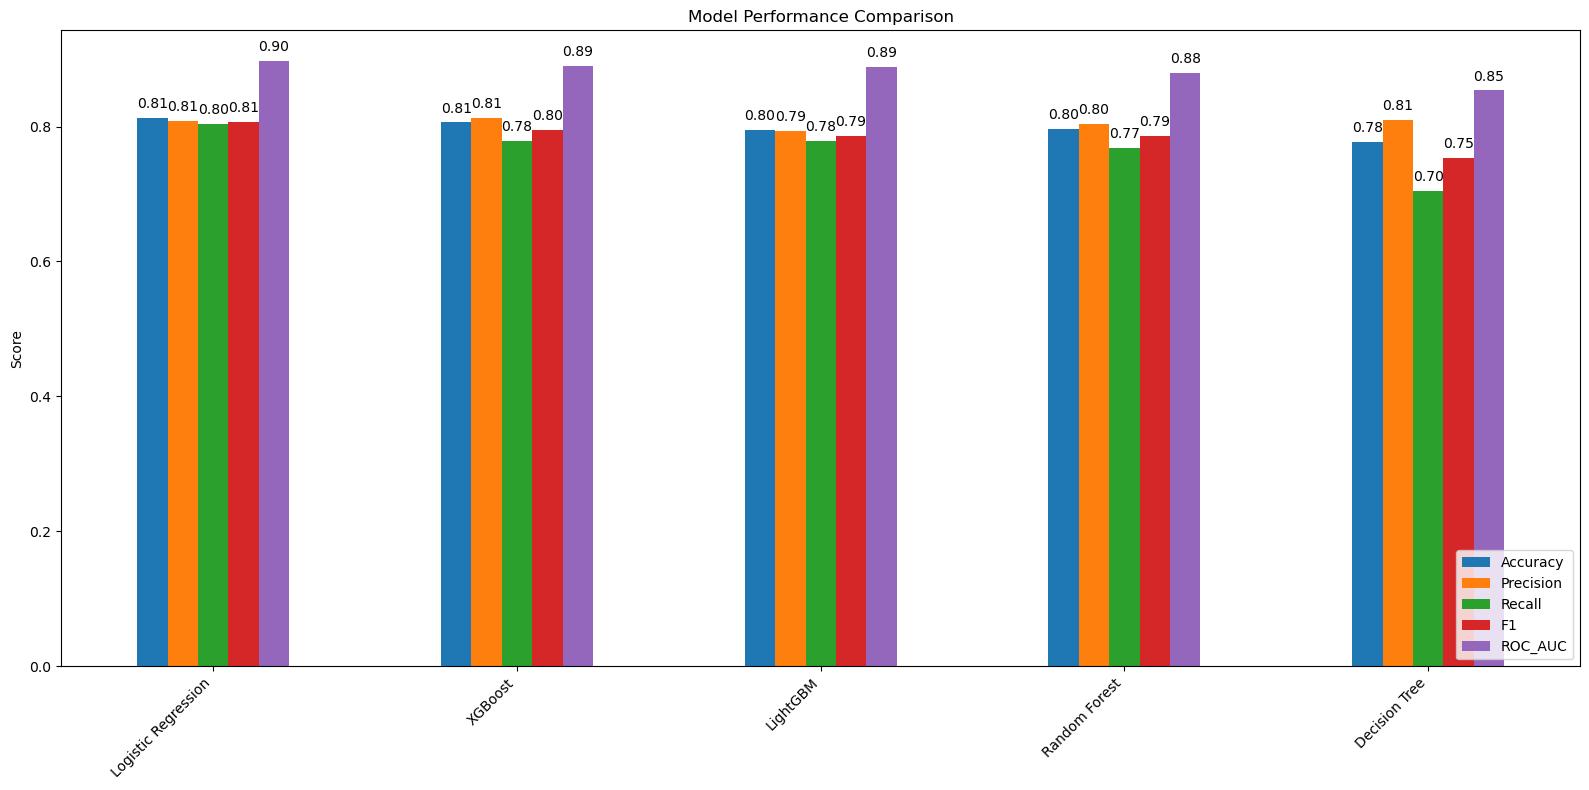

In [58]:
# -------------------------
# Model comparison bar chart
# -------------------------
ax = baseline_results_df.plot(kind="bar", figsize=(16, 8)) # Increased figure width for more space
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")

# Add values on top of each bar with padding
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=5) # Added padding to lift labels slightly

plt.legend(loc='lower right') # Move legend to the bottom right corner
plt.tight_layout()
plt.show()

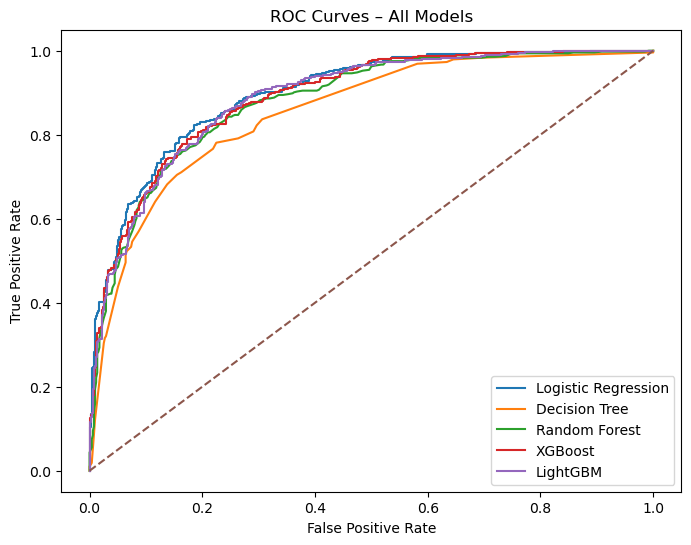


ROC-AUC Values for Each Model:
                      ROC_AUC
Logistic Regression  0.897683
XGBoost              0.889891
LightGBM             0.888029
Random Forest        0.879497
Decision Tree        0.853436


In [59]:
# -------------------------
# ROC curves for all models
# -------------------------
plt.figure(figsize=(8, 6))
for name, (fpr, tpr) in baseline_roc.items():
    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curves – All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Display ROC-AUC values in a table
print("\nROC-AUC Values for Each Model:")
print(baseline_results_df[['ROC_AUC']])

# **BEST MODEL DIAGNOSTICS**

The best model based on F1-score is: Logistic Regression with an F1-score of 0.81
ROC_AUC was chosen as the primary metric due to potential class imbalance and the need for a balanced measure of precision and recall.


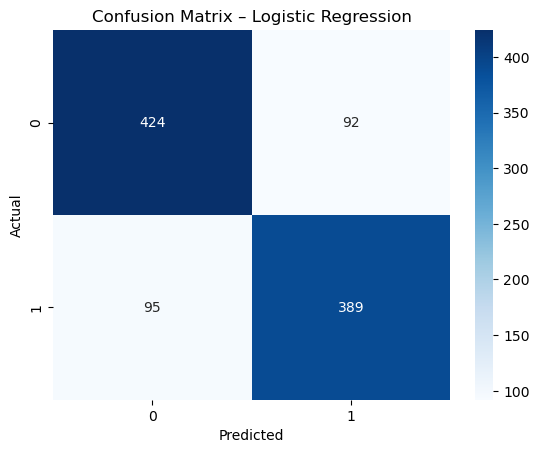

is_weekend_created          2.223759
congestion_index            1.423713
missing_docs_proxy          1.278778
shipment_mode_AIR           1.199501
doc_amendments              1.073236
shipment_mode_SEA           1.024919
commodity_Mangoes           0.710269
commodity_Pineapples        0.489093
commodity_Avocados          0.446716
hs_code_709                 0.408074
commodity_Vegetables Mix    0.408074
hs_code_902                 0.274607
commodity_Tea               0.274607
hs_code_1211                0.273791
commodity_Fresh Herbs       0.273791
dtype: float64


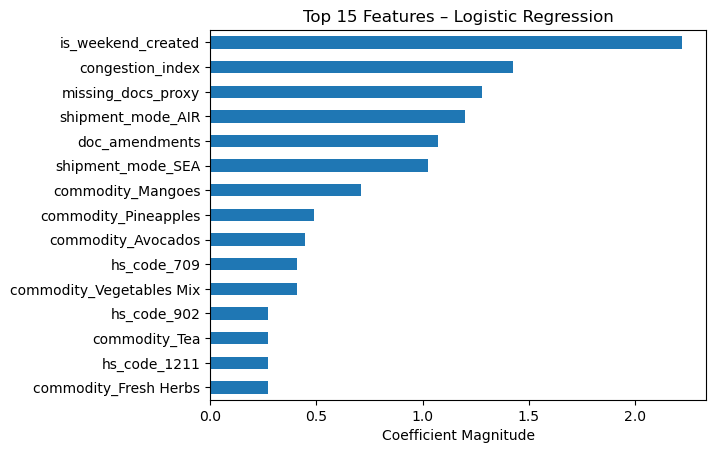

In [60]:
# Identify best model by F1-score
best_model_name = baseline_results_df.index[0]
best_f1_score = baseline_results_df.loc[best_model_name, "F1"]

print(
    f"The best model based on F1-score is: {best_model_name} "
    f"with an F1-score of {best_f1_score:.2f}"
)
print(
    "ROC_AUC was chosen as the primary metric due to potential class imbalance "
    "and the need for a balanced measure of precision and recall."
)

# -------------------------
# Retrieve the best pipeline directly (no models dict now)
# -------------------------
best_pipeline = baseline_best_estimators[best_model_name]

# Confusion matrix
cm = confusion_matrix(y_test, best_pipeline.predict(X_test))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix – {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# -------------------------
# Feature importance / coefficients
# -------------------------
model_step = best_pipeline.named_steps["model"]

feature_names = (
    numeric_features
    + binary_features
    + list(
        best_pipeline.named_steps["preprocessor"]
        .named_transformers_["cat"]
        .get_feature_names_out(categorical_features)
    )
)

# Tree models vs linear model handling
if hasattr(model_step, "feature_importances_"):
    importance = model_step.feature_importances_
    importance_label = "Feature Importance"
elif hasattr(model_step, "coef_"):
    importance = np.abs(model_step.coef_[0])
    importance_label = "Coefficient Magnitude"
else:
    importance = None
    importance_label = None

if importance is not None:
    fi = pd.Series(importance, index=feature_names).sort_values(ascending=False).head(15)
    print(fi)
    fi.plot(kind="barh")
    plt.title(f"Top 15 Features – {best_model_name}")
    plt.xlabel(importance_label)
    plt.gca().invert_yaxis()
    plt.show()
else:
    print("No feature importances available for this model.")

# MODEL ITERATION: RIDGE & LASSO LOGISTIC REGRESSION (POST-BASELINE)
### Applied only after confirming baseline Logistic Regression is the best-performing model to optimize and select features.

In [66]:
logistic_variants = {
    "Logistic (Unregularized)": LogisticRegression(
        solver='lbfgs',
        max_iter=1000,
        class_weight="balanced"
    ),
    "Logistic Ridge (L2)": LogisticRegression(
        penalty="l2",
        max_iter=1000,
        class_weight="balanced"
    ),
    "Logistic Lasso (L1)": LogisticRegression(
        penalty="l1",
        solver="saga",
        max_iter=2000,
        class_weight="balanced"
    )
}

regularized_results = {}

for name, model in logistic_variants.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    grid = GridSearchCV(
        pipe,
        {"model__C": [0.01, 0.1, 1, 10]},
        scoring="f1",
        cv=cv,
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    regularized_results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, y_prob)
    }

regularized_results_df = pd.DataFrame(regularized_results).T
regularized_results_df

,Accuracy,Precision,Recall,F1,ROC_AUC
Logistic (Unregularized),0.813,0.808732,0.803719,0.806218,0.897683
Logistic Ridge (L2),0.813,0.808732,0.803719,0.806218,0.897683
Logistic Lasso (L1),0.813,0.808732,0.803719,0.806218,0.897719


In [62]:
# Logistic variants including Elastic Net
logistic_variants = {
    "Logistic (Unregularized)": LogisticRegression(
        penalty=None,
        max_iter=1000,
        class_weight="balanced"
    ),
    "Logistic Ridge (L2)": LogisticRegression(
        penalty="l2",
        max_iter=1000,
        class_weight="balanced"
    ),
    "Logistic Lasso (L1)": LogisticRegression(
        penalty="l1",
        solver="saga", # Corrected solver to a valid one for L1 penalty
        max_iter=2000,
        class_weight="balanced"
    ),
    "Logistic ElasticNet": LogisticRegression(
        penalty="elasticnet",
        solver="saga", # Corrected solver to a valid one for ElasticNet penalty
        max_iter=2000,
        class_weight="balanced"
    )
}

regularized_results = {}

for name, model in logistic_variants.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    # Hyperparameter grid
    if name == "Logistic ElasticNet":
        param_grid = {
            "model__C": [0.01, 0.1, 1, 10],
            "model__l1_ratio": [0.1, 0.5, 0.9]  # Elastic Net mixing ratio
        }
    elif name == "Logistic (Unregularized)":
        param_grid = {}
    else:
        param_grid = {
            "model__C": [0.01, 0.1, 1, 10]
        }

    grid = GridSearchCV(
        pipe,
        param_grid,
        scoring="f1",
        cv=cv,
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    regularized_results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, y_prob)
    }

# Convert results to DataFrame
regularized_results_df = pd.DataFrame(regularized_results).T

# Highlight best metric per column
highlight_best = regularized_results_df.style.highlight_max(axis=0, color="lightgreen")
highlight_best

,Accuracy,Precision,Recall,F1,ROC_AUC
Logistic (Unregularized),0.813000,0.808732,0.803719,0.806218,0.897599
Logistic Ridge (L2),0.813000,0.808732,0.803719,0.806218,0.897683
Logistic Lasso (L1),0.813000,0.808732,0.803719,0.806218,0.897719
Logistic ElasticNet,0.813000,0.808732,0.803719,0.806218,0.897755


Best model based on ROC_AUC score: Logistic ElasticNet
                     feature  coefficient
6         is_weekend_created     2.235068
5           congestion_index     1.424564
3         missing_docs_proxy     1.288822
7          shipment_mode_AIR    -1.160741
4             doc_amendments     1.073068
8          shipment_mode_SEA     0.883464
13         commodity_Mangoes     0.604836
14      commodity_Pineapples    -0.402178
9         commodity_Avocados    -0.402053
19               hs_code_709    -0.362171
16  commodity_Vegetables Mix    -0.362171
25         origin_country_RW     0.270738
28    destination_country_BE     0.265965
21               hs_code_902    -0.227222
15             commodity_Tea    -0.227222


/var/folders/nn/6v8sy6r911d4ly_fvkqm3r6c0000gn/T/ipykernel_4293/3816035698.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


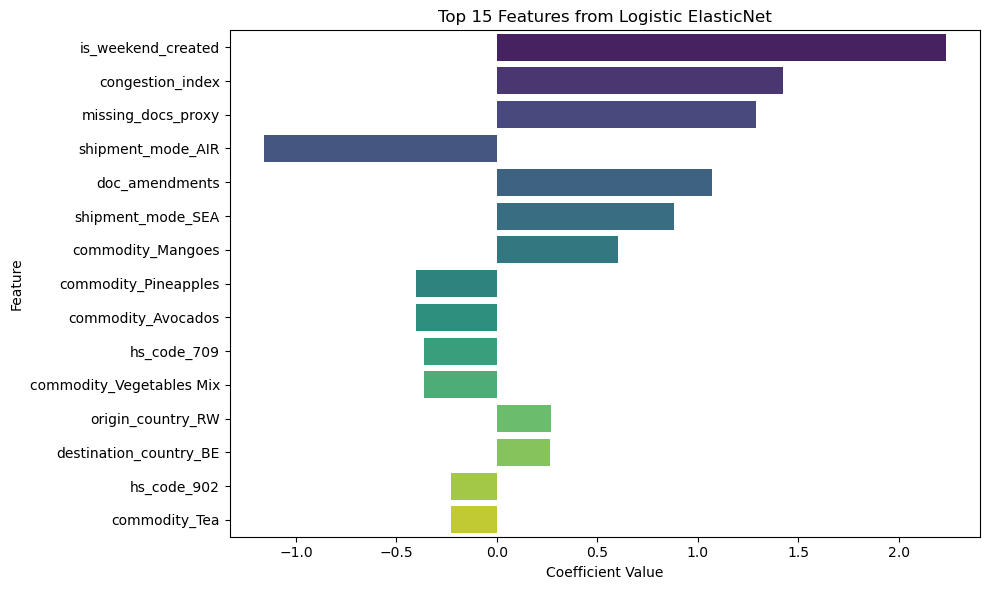

In [63]:

# FINAL MODEL INTERPRETATION (BEST LOGISTIC MODEL)

# Pick the best model based on ROC_AUC score
best_model_name = regularized_results_df["ROC_AUC"].idxmax()
print(f"Best model based on ROC_AUC score: {best_model_name}")

# Refit the best model on the full training data
best_model = GridSearchCV(
    Pipeline([
        ("preprocessor", preprocessor),
        ("model", logistic_variants[best_model_name])
    ]),
    {"model__C": [0.01, 0.1, 1, 10]} if best_model_name != "Logistic ElasticNet" else
    {"model__C": [0.01, 0.1, 1, 10], "model__l1_ratio": [0.1, 0.5, 0.9]},
    scoring="f1",
    cv=cv
).fit(X_train, y_train).best_estimator_

# Extract encoded feature names
encoded_feature_names = (
    numeric_features +
    binary_features +
    list(
        best_model.named_steps["preprocessor"]
        .named_transformers_["cat"]
        .get_feature_names_out(categorical_features)
    )
)

# Get model coefficients
coeffs = best_model.named_steps["model"].coef_[0]

coef_df = pd.DataFrame({
    "feature": encoded_feature_names,
    "coefficient": coeffs
})

# Keep only non-zero coefficients and sort by absolute value
selected_features = coef_df[coef_df["coefficient"] != 0]
selected_features = selected_features.reindex(
    selected_features.coefficient.abs().sort_values(ascending=False).index
)

# Display top 15 features
print(selected_features.head(15))

# Visualize top features
plt.figure(figsize=(10, 6))
sns.barplot(
    data=selected_features.head(15),
    x="coefficient",
    y="feature",
    palette="viridis"
)
plt.title(f"Top 15 Features from {best_model_name}")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


/var/folders/nn/6v8sy6r911d4ly_fvkqm3r6c0000gn/T/ipykernel_4293/927412945.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


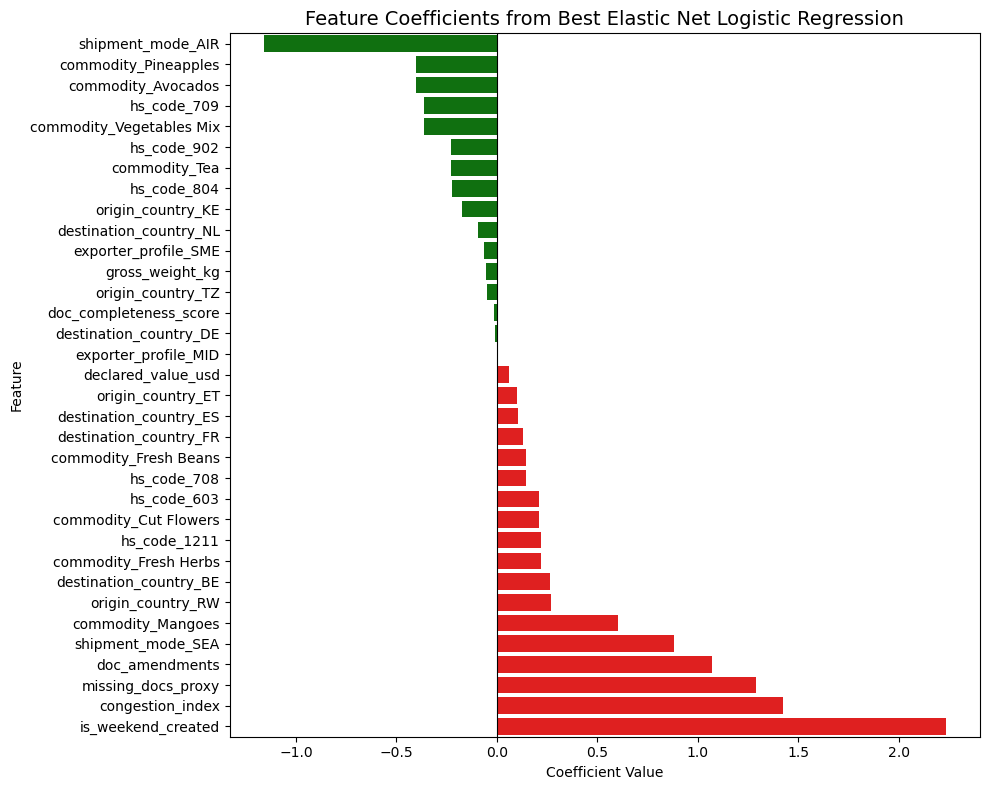

In [64]:

# FEATURE IMPORTANCE VISUALIZATION

# Sort coefficients for visualization
selected_features_sorted = selected_features.sort_values("coefficient", ascending=True).copy()

# Create a color column: red for causes delay, green for does not cause delay
selected_features_sorted["color"] = selected_features_sorted["coefficient"].apply(lambda x: "red" if x > 0 else "green")

plt.figure(figsize=(10, 8))

# Horizontal bar plot
sns.barplot(
    x="coefficient",
    y="feature",
    data=selected_features_sorted,
    palette=selected_features_sorted["color"].to_list()  # Pass a list of colors
)

plt.title("Feature Coefficients from Best Elastic Net Logistic Regression", fontsize=14)
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.axvline(0, color="black", linewidth=0.8)  # Line at zero for reference
plt.tight_layout()
plt.show()


# **MODEL RE-EVALUATION BASED ON SELECTED FEATURES**

In [65]:
# Use only selected features from best logistic model
selected_feature_names = selected_features["feature"].tolist()

# Transform X_train and X_test to keep only selected features
# If using ColumnTransformer, get transformed arrays
X_train_selected = best_model.named_steps["preprocessor"].transform(X_train)
X_test_selected = best_model.named_steps["preprocessor"].transform(X_test)

# Only keep the columns corresponding to selected features
# Assuming order matches encoded_feature_names
selected_indices = [encoded_feature_names.index(f) for f in selected_feature_names]

X_train_selected = X_train_selected[:, selected_indices]
X_test_selected = X_test_selected[:, selected_indices]


tree_models = {
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

tree_results = {}

for name, model in tree_models.items():
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_selected)[:, 1]
    else:
        # For models that do not have predict_proba
        y_prob = y_pred

    tree_results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, y_prob)
    }

# Convert results to DataFrame
tree_results_df = pd.DataFrame(tree_results).T
tree_results_df


/opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:36:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 1935, number of negative: 2065
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1031
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.483750 -> initscore=-0.065023
[LightGBM] [Info] Start training from score -0.065023


,Accuracy,Precision,Recall,F1,ROC_AUC
Decision Tree,0.730,0.721074,0.721074,0.721074,0.729723
Random Forest,0.800,0.807359,0.770661,0.788584,0.878422
XGBoost,0.784,0.780335,0.770661,0.775468,0.872101
LightGBM,0.808,0.811966,0.785124,0.798319,0.887681


This step re-trained tree-based models using only the most important features selected from the best Logistic Regression model.
 
- The first step was extracting the most important features from the Logistic Regression model.
- We then transformed the training and test data using the same preprocessing pipeline.  
- Thirdly, We selected only the columns corresponding to the chosen features.  
- We then compared the Tree Based Models (Decision Tree, Random Forest, XGBoost, and LightGBM.) 
- We fitted each model on the reduced feature set and generated predictions on the test data.
- We computed Accuracy, Precision, Recall, F1-score, and ROC-AUC.
- We then summarized all model scores in a comparison table.

# **Observations from Feature Coefficients**

The table shows the top features selected by the Elastic Net logistic regression model along with their coefficients:

**Key patterns:**

1. Strongest positive predictors:

- is_weekend_created and congestion_index are the most influential factors increasing risk.

- Operational timing and congestion are critical factors.

2. Shipment mode effects:

- AIR reduces risk, while SEA increases it — indicating mode choice is important.

3. Documentation effects:

- Missing or amended documents (missing_docs_proxy, doc_amendments) increase likelihood of the target event.

4. Commodity and HS code effects:

- Some commodities (Mangoes, Fresh Herbs) slightly increase risk, while others (Pineapples, Avocados, Tea) slightly reduce it.

- Certain HS codes also contribute positively or negatively, reflecting underlying regulatory or handling patterns.

**Discussion on Model Performance**

- Logistic regression with Elastic Net regularization outperformed all other models, including tree-based models like Decision Tree, Random Forest, XGBoost, and LightGBM.

- Elastic Net combines L1 and L2 penalties, which: Selects important features (like Lasso) and Stabilizes coefficients (like Ridge) for correlated features.




- This explains why logistic regression with Elastic Net could achieve better generalization than the more flexible tree-based models on this dataset.

- Using features selected by Elastic Net in tree-based models may improve their performance, but they did not surpass the logistic model in our evaluation — suggesting that the linear relationships captured by logistic regression are dominant, and unnecessary complexity from tree ensembles does not add predictive power here.

**Conclusions**

1. Best Model:

- Elastic Net-enhanced logistic regression.

- Achieves strong F1 score, ROC-AUC, and interpretable feature selection.

2. Feature Insights:

- Weekend shipments, congestion, shipment mode, and documentation issues are the most critical predictors.

- Commodity type and HS code have moderate effects.

3. Operational Implications:

- Interventions could focus on high-risk shipments flagged by the model.

- Monitoring weekend operations, congestion points, and document completeness could reduce risk.

4. Interpretability Advantage:

- Logistic regression coefficients allow direct interpretation of feature effects, unlike black-box models (XGBoost/LightGBM), which is valuable for business decisions.